In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input


In [4]:
data=pd.read_csv('csp.csv')
data.head()

,property_age,property_type,property_size_sqft,num_rooms,num_bathrooms,location_area,avg_market_price_per_sqft,requested_price,loan_to_value_ratio,approval_status
0,16,Apartment,3041,1,1,Gopanpally,19774.24,60133453.41,67.69,1
1,7,Apartment,2167,4,2,Banjara Hills,12466.35,27014584.37,83.73,0
2,34,Apartment,1825,6,2,Moula Ali,18849.44,34400230.42,55.88,1
3,30,Independent House,993,3,5,Rampally,9076.77,9013235.32,65.36,0
4,33,Apartment,4652,5,4,Kandukur,16186.66,75300357.92,76.70,1


In [5]:
print(data.isnull().sum())  # Check if any column has missing values


property_age                 0
property_type                0
property_size_sqft           0
num_rooms                    0
num_bathrooms                0
location_area                0
avg_market_price_per_sqft    0
requested_price              0
loan_to_value_ratio          0
approval_status              0
dtype: int64


In [6]:
def one_hot_encode(df,column_dict):
    df=df.copy()
    for column ,prefix in column_dict.items():
        dummies=pd.get_dummies(df[column], prefix=prefix)
        df=pd.concat([df,dummies],axis=1)
        df=df.drop(column,axis=1)
    
    return df

In [7]:
def preprocess_inputs(df):
    df=df.copy()
    nominal_feature_dict={
        'property_type':'Property Type',
        'location_area':'Location Area'
    }

    df=one_hot_encode(df,nominal_feature_dict)
 

    y=df['approval_status'].copy()
    X=df.drop('approval_status',axis=1).copy()
    
    X_train,X_test,y_train,y_test= train_test_split(X,y,train_size=0.5,random_state=123)
    scaler=StandardScaler()
    scaler.fit(X_train)
    
    X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
    return X_train, X_test, y_train, y_test

In [8]:
X_train,X_test,y_train,y_test=preprocess_inputs(data)

In [9]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)



In [10]:
X_train

<tf.Tensor: shape=(2499, 109), dtype=float32, numpy=
array([[-1.0305972 , -0.7493545 ,  0.31859723, ..., -0.09638038,
        -0.10052409, -0.09205746],
       [ 0.22872919,  1.3435823 ,  0.31859723, ..., -0.09638038,
        -0.10052409, -0.09205746],
       [ 1.418093  , -0.78426266,  0.31859723, ..., -0.09638038,
        -0.10052409, -0.09205746],
       ...,
       [-0.890672  ,  0.5988753 ,  1.500742  , ..., -0.09638038,
        -0.10052409, -0.09205746],
       [-0.19104627,  0.85564405, -0.27247512, ..., -0.09638038,
        -0.10052409, -0.09205746],
       [-1.3104475 ,  0.8921037 , -0.8635475 , ..., -0.09638038,
        -0.10052409, -0.09205746]], dtype=float32)>

In [11]:
print(type(X_train))  # Should be <class 'pandas.DataFrame'>


<class 'tensorflow.python.framework.ops.EagerTensor'>


In [12]:
from tensorflow.keras.layers import Dropout,Input
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train.numpy()), 
                                     y=y_train.numpy().astype(int))

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Drop 30% of neurons randomly
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight_dict,)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4796 - loss: 0.8671 - val_accuracy: 0.5176 - val_loss: 0.7007
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5175 - loss: 0.7327 - val_accuracy: 0.5540 - val_loss: 0.6838
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5374 - loss: 0.6992 - val_accuracy: 0.5776 - val_loss: 0.6766
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5487 - loss: 0.6856 - val_accuracy: 0.5852 - val_loss: 0.6723
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5694 - loss: 0.6746 - val_accuracy: 0.6132 - val_loss: 0.6631
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5839 - loss: 0.6753 - val_accuracy: 0.6324 - val_loss: 0.6557
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6270 - loss: 0.6505 - val_accuracy: 0.6376 - val_loss: 0.6423
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5812 - loss: 0.6637 - val_accuracy: 0.6572 - val_loss:

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7502 - loss: 0.5181
Test Accuracy: 0.74


In [16]:
y_train_np = y_train.numpy() 
print("Class distribution:", np.bincount(y_train_np.astype(int)))

Class distribution: [1150 1349]


In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  

print(classification_report(y_test, y_pred))


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.58      0.68      1205
         1.0       0.70      0.90      0.78      1295

    accuracy                           0.74      2500
   macro avg       0.77      0.74      0.73      2500
weighted avg       0.77      0.74      0.74      2500



79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


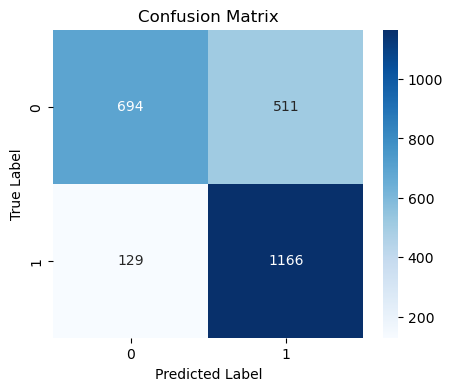

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test) >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


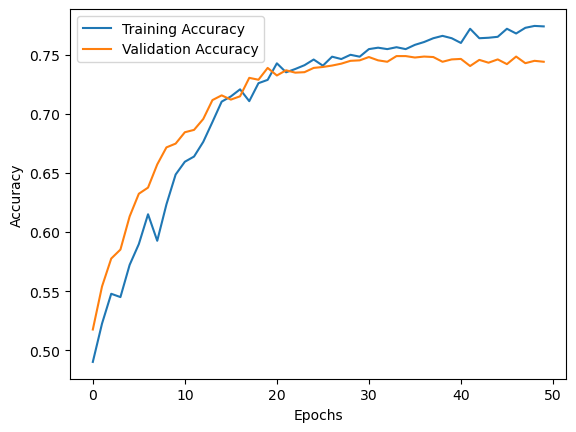

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
